In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import sim_models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns
from autocorr_time import integrated_time

In [2]:
# Which data to load?
# E_min : [0.676, 0.84 , 1.269, 1.741, 2.12 , 2.609, 2.609, 3.586, 4.332, 5.475]
# E_max : [0.706, 0.868, 1.292, 1.759, 2.137, 2.624, 2.624, 3.598, 4.342, 5.484]
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'

# Select the parameterization
# parameterization = 'init-f-wave'
parameterization = 'sim_bs_C'

# Use theory cov?
use_theory_cov = True

# # Information about the sampling
# n_burn = 50000
# n_steps = 200000

number = 0
titles = ['SONIK Data 0.676 MeV - 2.624 MeV\nWith theory covariance']

# Samples file
numbers = 0
file_name = './05_01_2024/run{}/samples_{}.npz'.format(numbers, numbers)

# Plot things?
plot_trace = False
plot_prob = False

# Set a specific prior? (Default set: None)
param_bounds = None
params_prior = None

# Correlation matrix (only ERPs vs. include all ERPs + norm)
just_ERPs = True

# Plot cross sections?
# If true, this takes a long time if they are not precomputed
plot_cs = False
# Cross sections file (If I precompute them)
cross_section_file = None


In [3]:
loader = DataLoader(E_min, E_max, which_data)

data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

In [4]:
if parameterization == 'sim_bs_C':
    labels = ['$\\bar{c}^{2}$', '$\Lambda_{B}$', '$A_{0}$', '$r_{0}$', '$(C_{1}^{+})^{2}$', '$P_{1}^{+}$', '$(C_{1}^{-})^{2}$', '$P_{1}^{-}$']
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = sim_models.Sim_BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
else:
    sys.stderr.write('Nothing else is implemented yet...')
    sys.exit(-1)

# Add normalization labels
if labels is not None:
    for i in range(0, int(np.max(norm_group) + 1)):
        labels.append('$f_{}$'.format(i))

In [5]:
# Load in the samples
all_samples = np.load(file_name)['arr_0']

samples_not_flat = all_samples[0] # Just the beta = 1 samples
# Swap axes so it is in the shape (step, walker, parameter)
samples_not_flat = np.swapaxes(samples_not_flat, 0, 1)

# # Reshape the samples
# len0, len1, len2 = samples_not_flat.shape
# samples = np.reshape(samples_not_flat, (len0 * len1, len2))

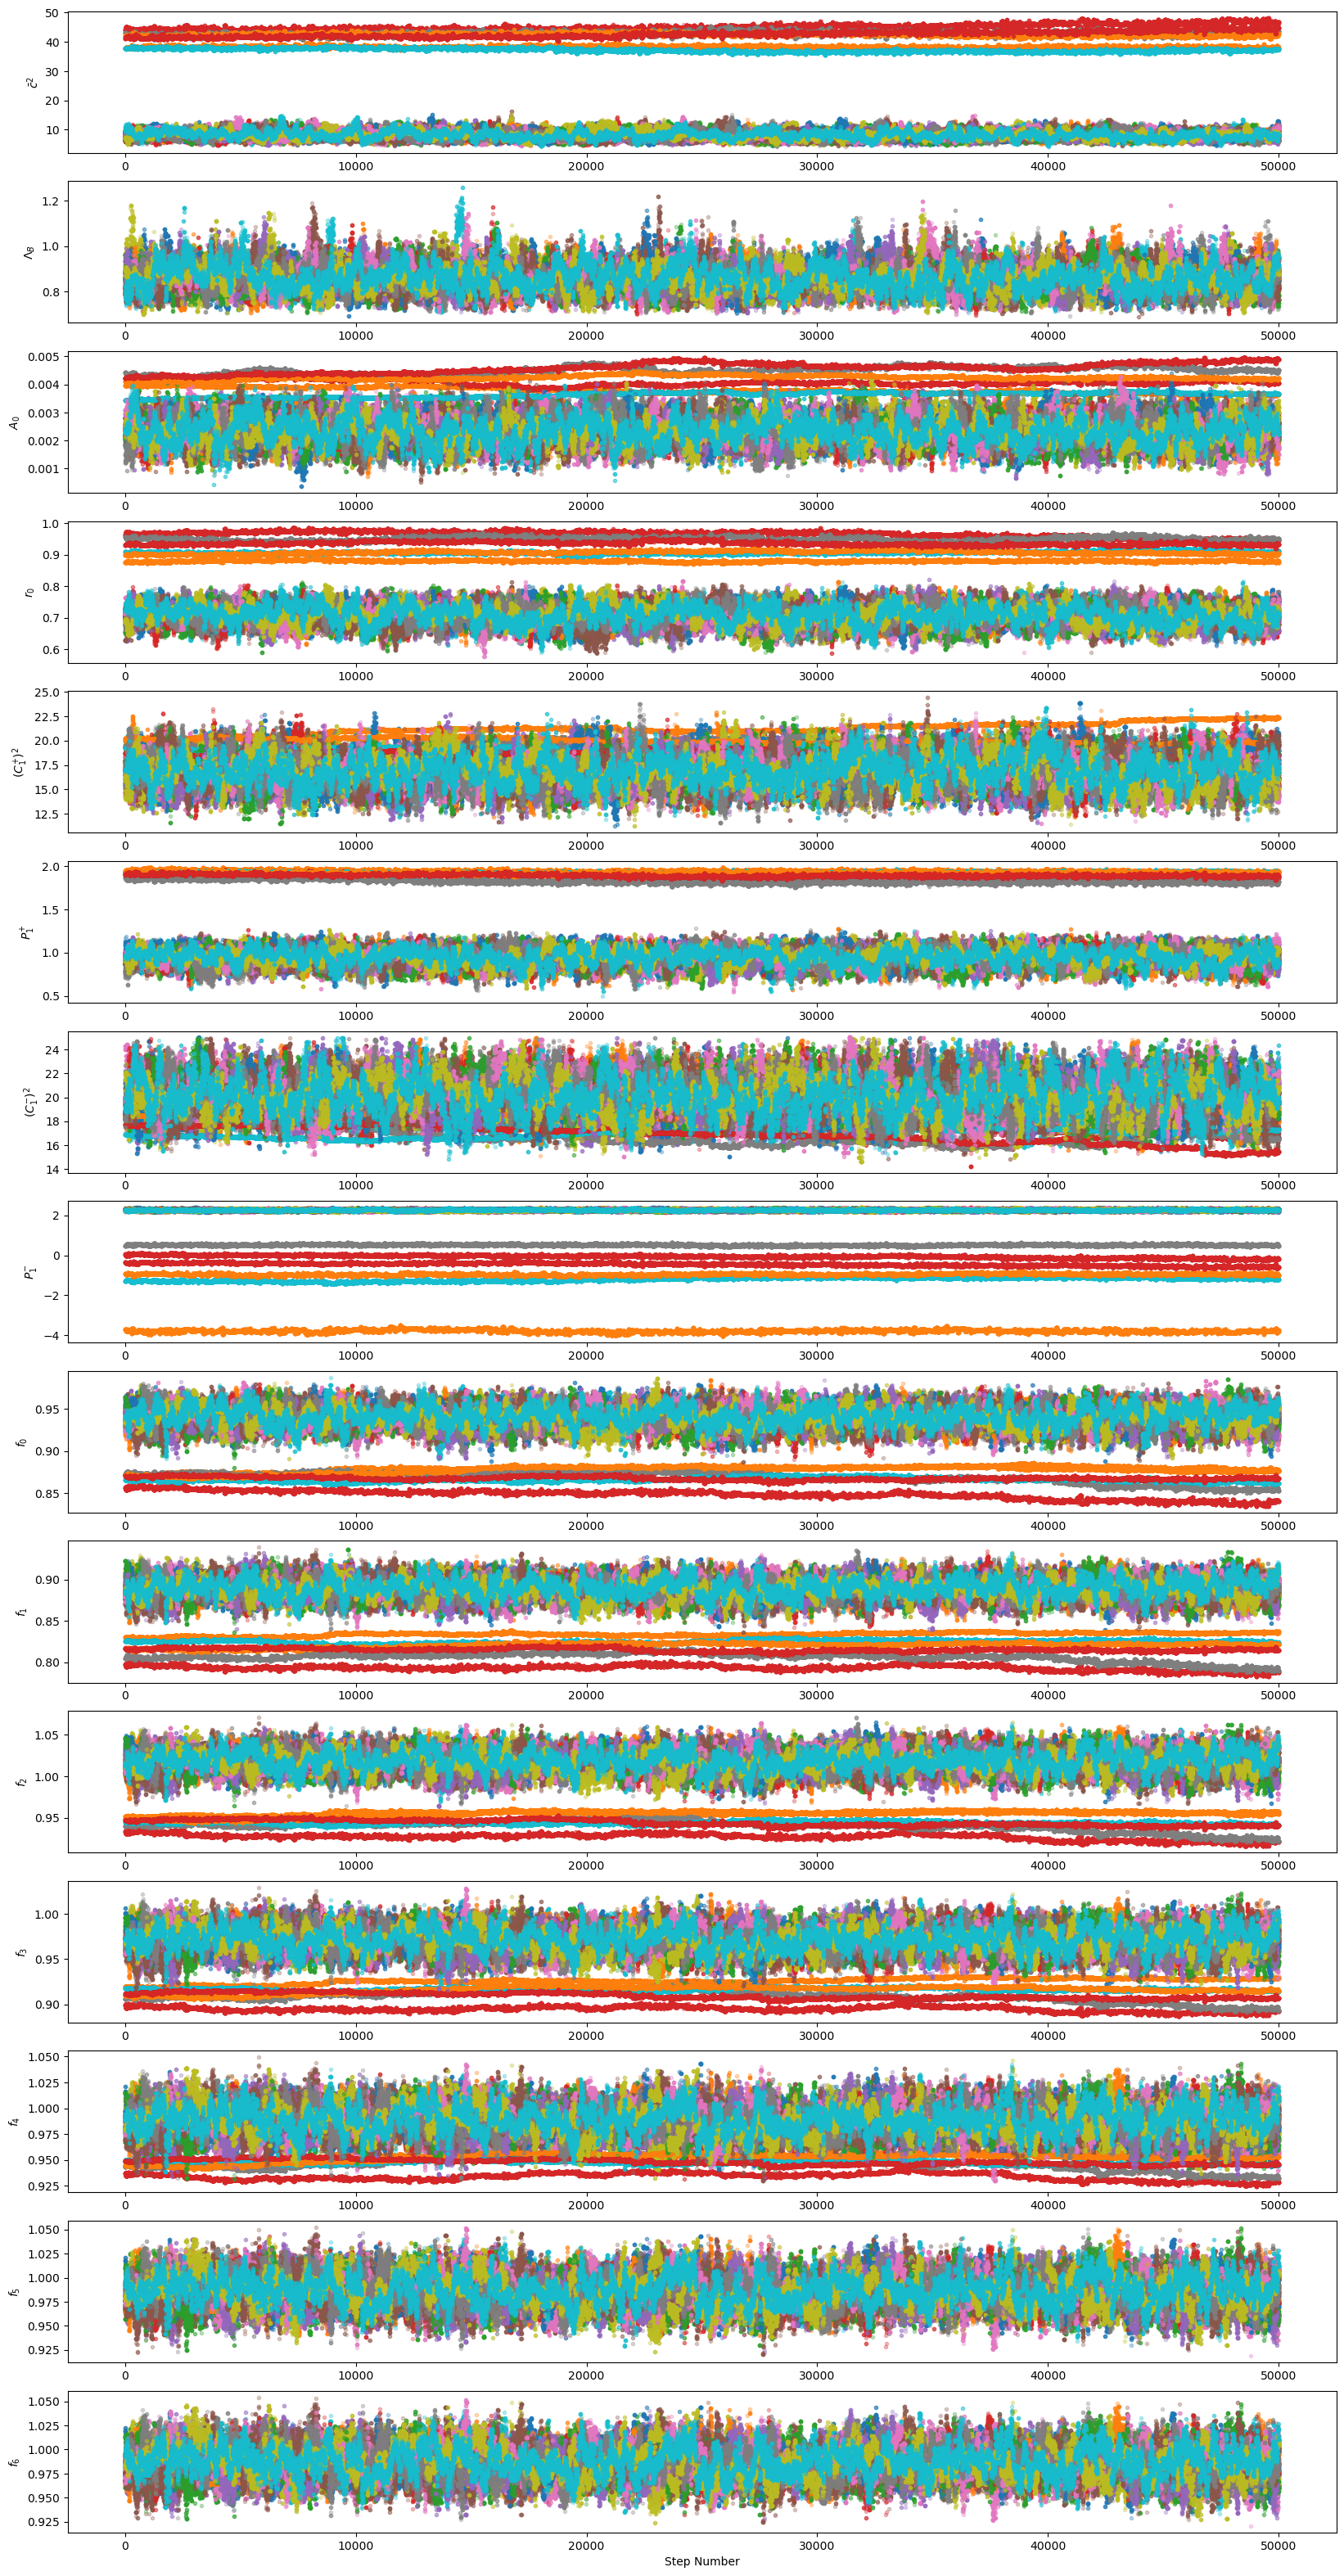

In [6]:
def generate_trace_plot(samples_not_flat):
    # Generate the trace plot given a set of samples
    fig, axes = plt.subplots(samples_not_flat.shape[2], figsize = (20, 40))
    for i in range(0, samples_not_flat.shape[2]):
        ax = axes[i]
        for j in range(0, samples_not_flat.shape[1]):
            ax.plot(samples_not_flat[:, :, i][:, j], '.', alpha = 0.3)
        # ax.plot(samples_not_flat[:, :, i][:, 0], '.', alpha = 0.3)
            ax.set_ylabel(labels[i])
    axes[-1].set_xlabel('Step Number')
    plt.show()

generate_trace_plot(samples_not_flat)

In [ ]:
# Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
within_chain_means = np.mean(samples_not_flat[:, :, :], axis = 0)

# Create an empty array of the within chain variances
within_chain_var = np.empty(within_chain_means.shape)

# Run a for loop across all walkers to compute the within chain variance
for i in range(0, within_chain_means.shape[0]):
    within_chain_var[i, :] = np.sum(np.square(within_chain_means[i, :] - samples_not_flat[:, i, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

# Get the typical within chain variance W for each parameter
W = np.median(within_chain_var, axis = 0)


# Now we need to loop over each chain for each parameter to see how it compares to the typical variance
bad_indices = []
ratios = np.empty(within_chain_means.shape)
# Loop over each parameter
for i in range(0, within_chain_means.shape[1]):
    # Loop over the walkers
    for j in range(0, within_chain_means.shape[0]):
        ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]
        ratios[j, i] = ratio

# Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
total_normalized_ratios = np.sum(ratios, axis = 1)
bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
print(bad_indices)

if bad_indices.shape[0] != 0:
    # Remove the bad walkers
    samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

In [7]:
# Flatten the samples
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(1500000, 15)


In [8]:
# Compute the autocorrelation times and thin
ac_s = integrated_time(samples_not_flat)
print(ac_s)
ac = int(np.ceil(np.max(ac_s)))
samples_not_flat = samples_not_flat[::ac, :, :]

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1000;
tau: [1372.93684968 1752.99906373 2252.67440423 1331.34757941 2315.6246627
  831.68654753 2640.28925788 1247.35746931 1980.58392454 1640.92285296
 1911.03489117 1813.07531346 1838.79259266 1864.95153282 1896.89964022]

In [9]:
# Flatten the samples
len0, len1, len2 = samples_not_flat.shape
samples = np.reshape(samples_not_flat, (len0 * len1, len2))
print(samples.shape)

(1500000, 15)


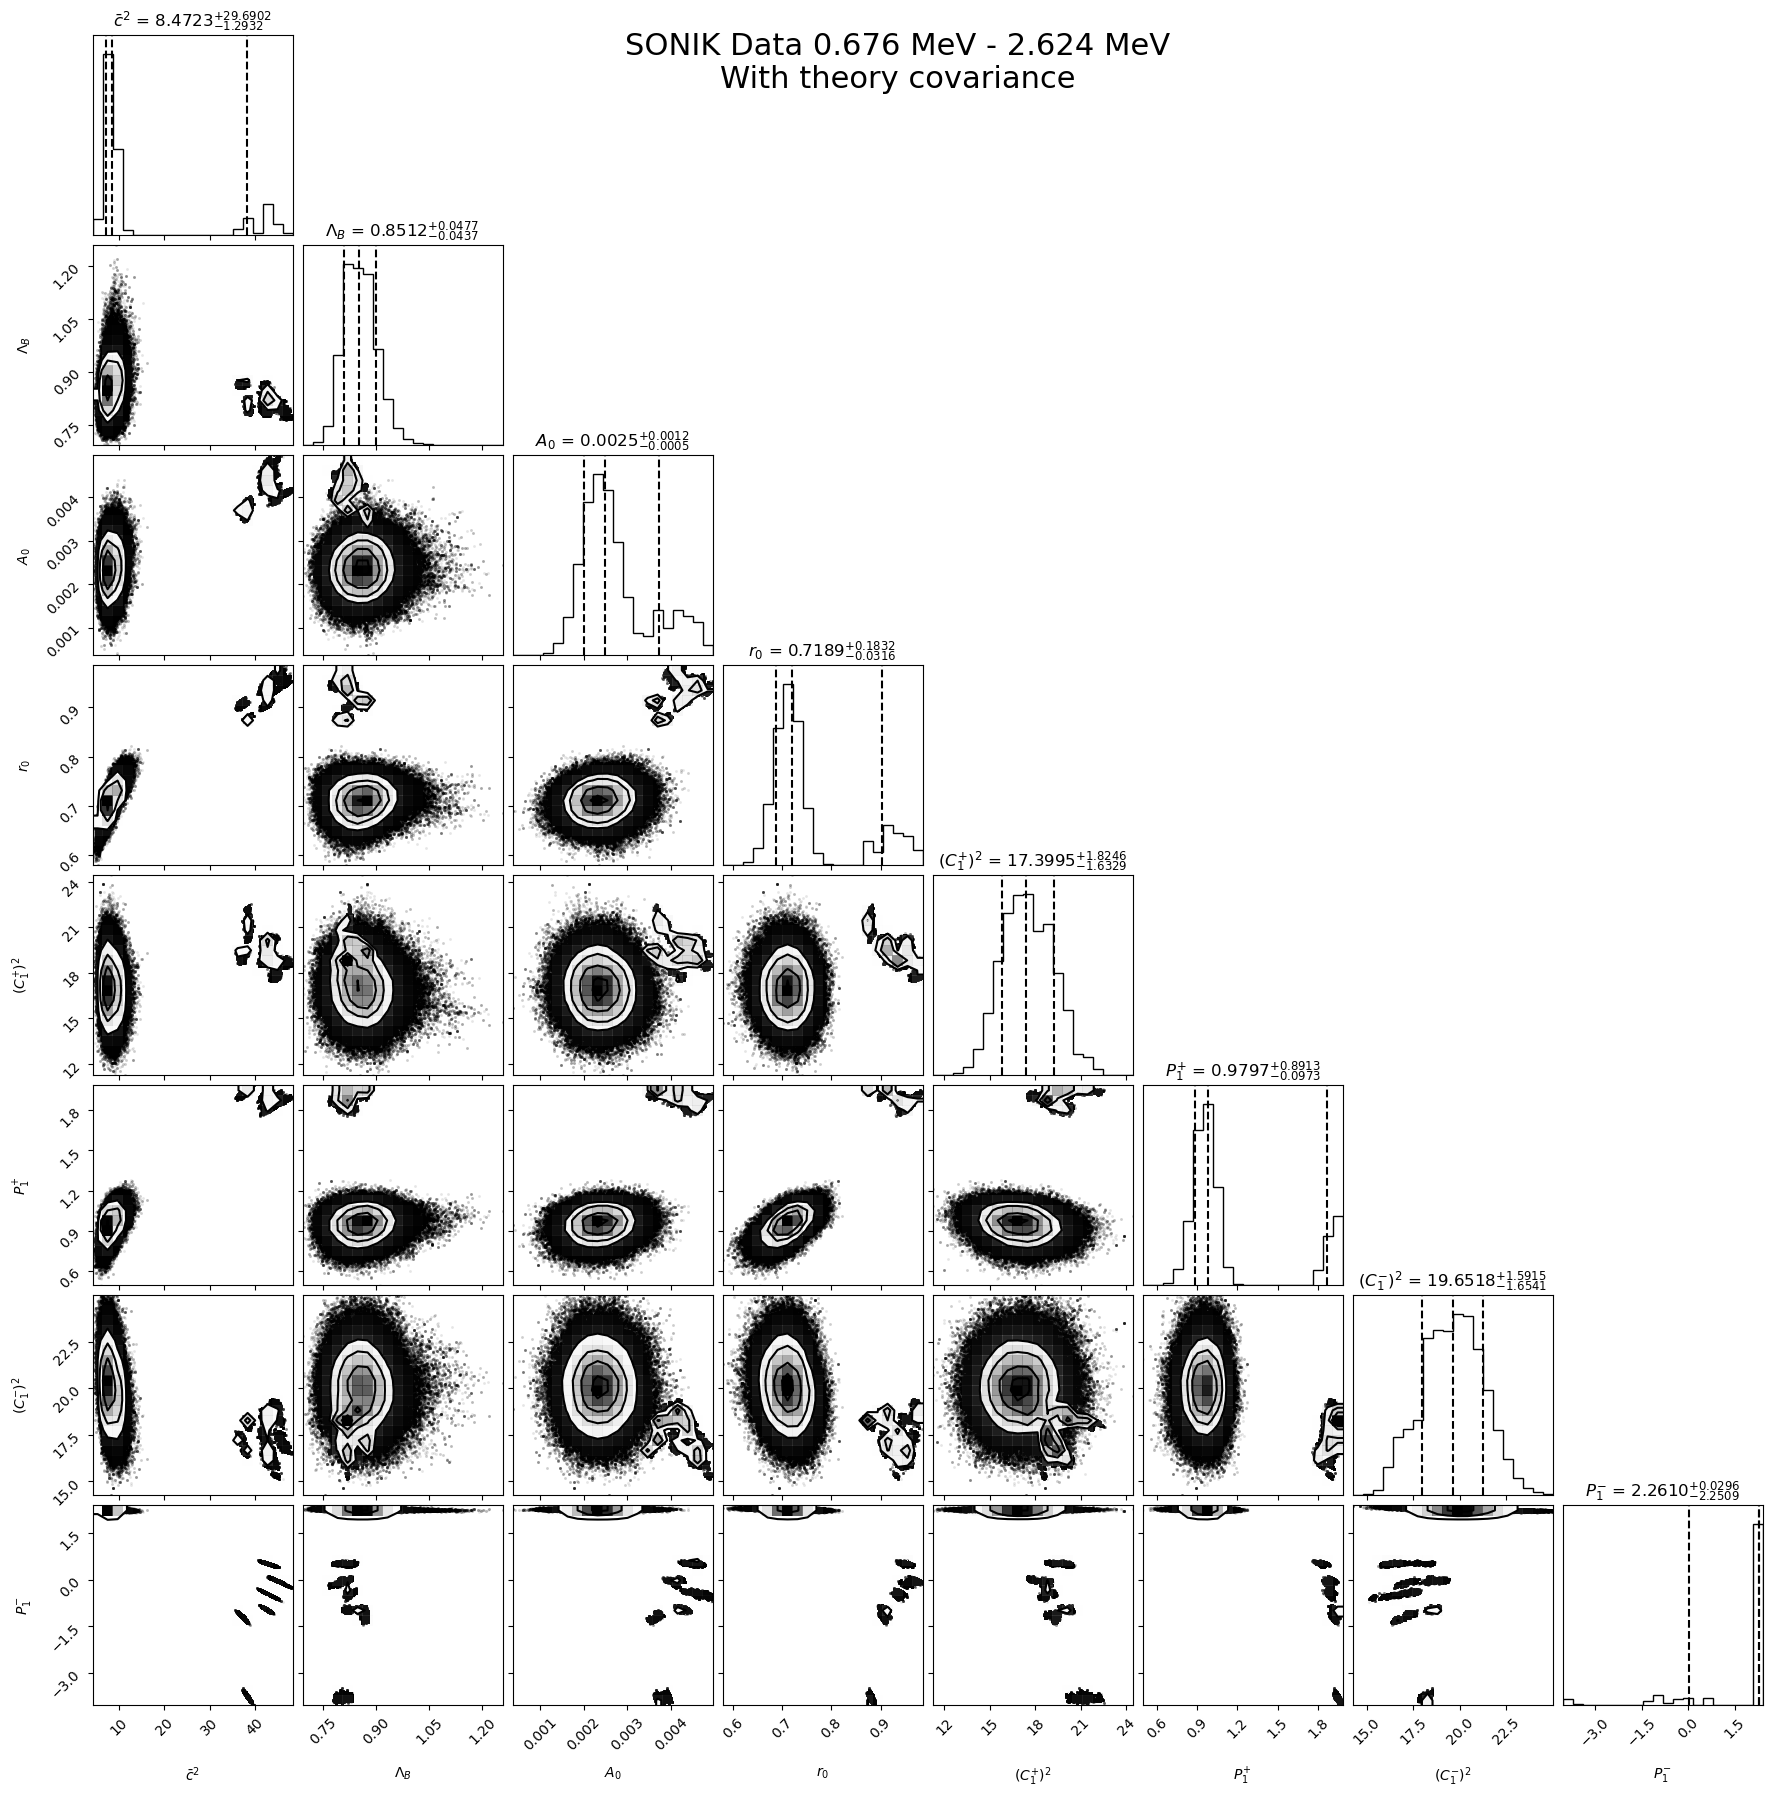

In [10]:
corner.corner(samples[:, :model.erp_dim + 2], labels = labels[:model.erp_dim + 2], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle(titles[number], fontsize = 22)
plt.show()

In [ ]:
corner.corner(samples, labels = labels, quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle(titles[number])
plt.show()

In [ ]:
print(np.quantile(samples[:, :], axis = 0, q = [0.5]))

In [ ]:
samples.shape